# Enobio Error Screening
Use this notebook to observe error potentials from the error screening task recorded using the NeuroElectrics Enobio (2019.01.10).

## TO DO LIST:
- Balance classes in classification
- Try classifying based on timeseries data, not spectrogram data (template projection method)
- Try classifying based on theta power

In [1]:
from matplotlib import pyplot as plt
import scipy.signal as scisig
import numpy as np
import pandas as pd
import csv

## Load the EEG data
Load in the data from the NIC2 .easy file and convert to a Pandas dataframe

In [2]:
def ConvertEasyToDataFrame(filename):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    import pandas as pd
    
    # Read in the .easy file
    df = pd.read_csv(filename, delimiter='\t', header=None)
    
    # Get metadata from the .info file
    fname = filename[:-5] + '.info'
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Get the channel names
    channel_info = [x for x in content if 'Channel ' in x]
    channel_names = []
    for ch in range(len(channel_info)):
        channel_names.append(channel_info[ch].split(': ')[1])
        
    channel_names.append('X')
    channel_names.append('Y')
    channel_names.append('Z')
    channel_names.append('STI 014')
    channel_names.append('DateTime')
    
    # Get sampling rates
    sampling_rates = [x for x in content if 'sampling rate: ' in x]
    fs_all = []
    for freq in range(len(sampling_rates)):
        fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

    # Store sampling rates
    fs = fs_all[0]
    fs_accel = fs_all[1]
    
    # Assign the column names
    df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
subjID = 'nile'
filename = '../data/Enobio/20190109110628_' + subjID + '_error_screening_R1.easy'

In [4]:
EEGdata, fs, fs_accel = ConvertEasyToDataFrame(filename)
EEGdata.head()

,Fz,FC1,Cz,C3,C4,Pz,P3,P4,X,Y,Z,STI 014,DateTime
0,-19328739,-21221211,-97813141,-4103851,-28058722,-1975250,-5630064,-136533658,0,0,0,0,1547060788488
1,-19176294,-21186068,-97833406,-4158115,-27985671,-2015447,-5710888,-136586253,0,0,0,0,1547060788490
2,-18994428,-21103766,-97810470,-4229164,-27882054,-2071476,-5837012,-136648814,0,0,0,0,1547060788492
3,-18948366,-21045973,-97766124,-4254913,-27839759,-2093363,-5898333,-136670748,0,0,0,0,1547060788494
4,-18979551,-21033718,-97740947,-4256678,-27845815,-2095508,-5910778,-136668459,0,0,0,0,1547060788496


In [5]:
# Check shape of the data
np.shape(EEGdata)

(173071, 13)

In [6]:
# Create the time array
time = np.linspace(0, np.shape(EEGdata)[0]/fs, np.shape(EEGdata)[0])

A pulse is sent every time the cursor moves in the opposite direction as what was expected. Note that the value of the event marker is equal to what number movement it corresponded to (there are skips because the values that are missing where when the cursor went in the expected direction).

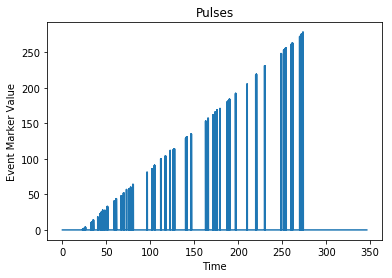

In [7]:
# Plot
plt.figure()
plt.plot(time, EEGdata['STI 014'])
plt.xlabel('Time')
plt.ylabel('Event Marker Value')
plt.title('Pulses')
plt.show()

In [8]:
# Check pulse value(s)
np.unique(EEGdata['STI 014'])

array([  0,   1,   2,   4,  10,  11,  14,  18,  23,  25,  28,  33,  41,
        44,  48,  52,  57,  58,  60,  64,  81,  86,  91, 100, 104, 112,
       113, 114, 129, 131, 135, 153, 157, 162, 166, 169, 171, 180, 181,
       184, 192, 205, 218, 219, 231, 248, 253, 255, 256, 261, 263, 272,
       275, 276, 278], dtype=int64)

Plot all channel data

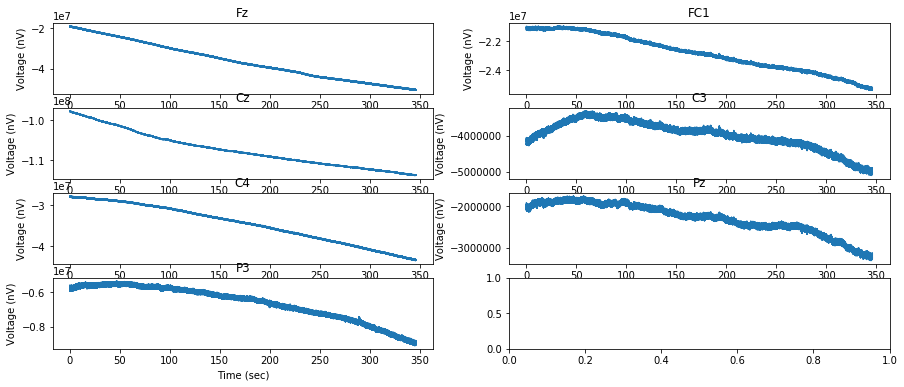

In [9]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
for chanOfInt in EEGdata.columns[0:7]:
    axs[i].plot(time, EEGdata[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

## Load the behavioral data

In [10]:
behavioral_file = '../data/Enobio/Error_Screening_nile_R1.csv'
behavioralData = pd.read_csv(behavioral_file, ',')
behavioralHeader = behavioralData.columns
behavioralData.head()

,Unnamed: 0,time,player_x,player_y,target_x,target_y,key_pressed,direction_moved,error_induced,score
0,0,2.977620,722.5,190.5,1177.5,191.0,right,right,False,0
1,1,3.944121,646.5,190.5,1177.5,191.0,right,left,True,0
2,2,4.865142,570.5,190.5,1177.5,191.0,right,left,True,0
3,3,5.793723,646.5,190.5,1177.5,191.0,right,right,False,0
4,4,6.513067,570.5,190.5,1177.5,191.0,right,left,True,0


### Sync up event markers / trigger pulses
Note that for the DSI-7, we sound audio beeps that are sent as pulses through the trigger hub and are recorded with the EEG. For the Enobio, we use Lab Streaming Layer (LSL) to send direct pulses with integer values to the recording software.

In [11]:
np.unique(EEGdata['STI 014'])

array([  0,   1,   2,   4,  10,  11,  14,  18,  23,  25,  28,  33,  41,
        44,  48,  52,  57,  58,  60,  64,  81,  86,  91, 100, 104, 112,
       113, 114, 129, 131, 135, 153, 157, 162, 166, 169, 171, 180, 181,
       184, 192, 205, 218, 219, 231, 248, 253, 255, 256, 261, 263, 272,
       275, 276, 278], dtype=int64)

In [12]:
# Ignore the first error if the first movement was error
# because the pulse value would be 0 and we wouldn't able to log that in index_trigger
behavioral_error_trials = np.where(behavioralData['error_induced']==True)[0]

# Only store info for trials that are confirmed to be error movement
# From both the EEG data and from the behavioral data
error_trials = np.intersect1d(np.unique(EEGdata['STI 014'])[1:], behavioral_error_trials)

Note that in the error screening task, subjects have to press the arrow key 3 times before the cursor will actually move. This is why we see three pulses of the same value. The cursor does not move until the third pulse is sent.

In [13]:
index_trigger = list()

# Start from 1 and not 0 because 0 is used for no pulse sent as well
for i in range(0,len(error_trials)):
    index_trigger.append(np.where(EEGdata['STI 014'] == error_trials[i])[0][-1])

In [14]:
print(index_trigger)

[11852, 12313, 13137, 16289, 16669, 17727, 20243, 21693, 22227, 24129, 25729, 29737, 30708, 33629, 35017, 37933, 38325, 39017, 40299, 48248, 51139, 52493, 56064, 58739, 63041, 63421, 63797, 70229, 70821, 73354, 81619, 82950, 85813, 87129, 88036, 93870, 94186, 95102, 98618, 105100, 110086, 110370, 115218, 124548, 126130, 126798, 127230, 130250, 130898, 135074, 135938, 136242, 136930]


In [15]:
np.shape(index_trigger)

(53,)

In [16]:
# Check number of trials
num_of_trials = behavioralData.shape[0]

In [17]:
num_of_error = len(index_trigger)
num_of_correct = num_of_trials - num_of_error - 1 # skipped the initial error movement because it had pulseValue 0

## Getting movement start times
I should have made the code such that it would send a pulse with a specific value for moving correctly and another value for moving incorrectly, but alas...

Because we don't have that information here, we will need to use the information from the behavioral data to figure out the start times. We need to figure out how much of a time difference there is between the time values recorded in the behavioral data (.csv) and between the timing of the pulses received in the EEG.

Every entry in the .csv is a movement. Every 3rd pulse (final pulse in series of three with same value) in the EEG correspond to entries in the .csv where the "error_induced" value is TRUE.

In [18]:
print('Time of second error in behavioral: ' + str(behavioralData['time'][behavioral_error_trials[0]]))
print('Time of second error in EEG: ' + str(index_trigger[0]/fs))

Time of second error in behavioral: 3.944120523286984
Time of second error in EEG: 23.704


In [19]:
t_diff_all = list()
for i in range(0, len(index_trigger)):
    t_diff_all.append((index_trigger[i]/fs)-behavioralData['time'][error_trials[i]])

print(t_diff_all)

[19.759879476713017, 19.76085790300183, 19.760932718660683, 19.76072753339261, 19.76071378589794, 19.76068206140399, 19.759731289198623, 19.76008509198576, 19.760338370777674, 19.761029213054112, 19.760022718125946, 19.759964624956247, 19.75896349599025, 19.75945156471989, 19.759256199948496, 19.75857590007037, 19.75904078977183, 19.75911731577107, 19.759648485809564, 19.758959758285428, 19.758348836397758, 19.75852805209719, 19.75911570803447, 19.75913119630144, 19.75782684149965, 19.757582046844078, 19.757336857687676, 19.758323466071857, 19.75864742347784, 19.758140420440583, 19.756764736596494, 19.758146682381636, 19.7564776084144, 19.75623866598309, 19.757619142372164, 19.757958951881164, 19.757756490519284, 19.757764851763852, 19.757251852856967, 19.756848466396292, 19.756970930358392, 19.75697908155621, 19.75574550266751, 19.75719151189918, 19.75483056133612, 19.755810349345182, 19.754420564779963, 19.755698095075786, 19.755507876075825, 19.755416420010846, 19.755079805454244, 1

To find times in EEG for all trials, add the value of t_0 to the respective behavioral data time.

In [20]:
t_0 = np.mean(t_diff_all)
t_0

19.75807821010489

In [21]:
t_trial_start = list()

for i in range(0, num_of_trials):
    t_trial_start.append(behavioralData['time'][i] + t_0)

t_trial_start

[22.735698002439626,
 23.702198733391874,
 24.62322030710306,
 25.551801153274887,
 26.27114549144421,
 29.51004435033787,
 30.386113503298425,
 30.985111744424962,
 31.518545091666915,
 32.05147922323335,
 32.57535067671228,
 33.33536442420695,
 34.06785412626591,
 34.66802616352465,
 35.4513961487009,
 36.07950248411176,
 39.03881771425036,
 39.93374632653098,
 40.48434692090626,
 41.15076739345926,
 41.719648869524406,
 42.33422838947986,
 42.86802398767572,
 43.383993118119136,
 43.9343479450817,
 44.45173983932722,
 44.98445252427149,
 45.552222926218704,
 48.25504899705078,
 49.02386237499554,
 49.52793161995028,
 50.050076300327376,
 50.7007234881657,
 51.456055491978944,
 51.99199003591452,
 52.56614655400876,
 53.288023449995265,
 56.672023086392024,
 57.392095767010645,
 58.11724188346665,
 58.768181560377286,
 59.47211358514864,
 60.01687528034922,
 60.61650010086846,
 61.41511471411464,
 62.03287129178893,
 62.72024472784501,
 66.71378244930197,
 67.256626645385,
 68.015953

In [22]:
# Get a nice list of whether a trial is error or not
isError = list()
correct_trials = list()
for i in range(0, len(behavioralData['error_induced'])):
    if behavioralData['error_induced'][i] == True:
        isError.append(1)
    else:
        isError.append(0)
        correct_trials.append(i)

correct_trials = np.asarray(correct_trials)

## Cleaning the EEG data
Artifact removal and filtering

In [23]:
from mne.filter import filter_data

In [24]:
EEGdata_filt = EEGdata.copy()
channels = EEGdata.columns[0:7]

eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=40)
EEGdata_filt[channels] = filtered.T

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


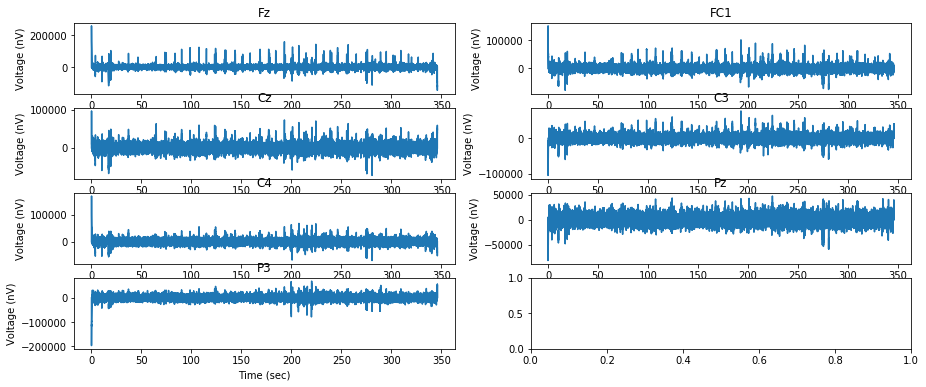

In [25]:
fig, axs = plt.subplots(4,2, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
i = 0
channels = EEGdata.columns[0:7]

for chanOfInt in channels:
    axs[i].plot(time, EEGdata_filt[chanOfInt])
    axs[i].set_xlabel('Time (sec)')
    axs[i].set_ylabel('Voltage (nV)')
    axs[i].set_title(chanOfInt)
    i += 1

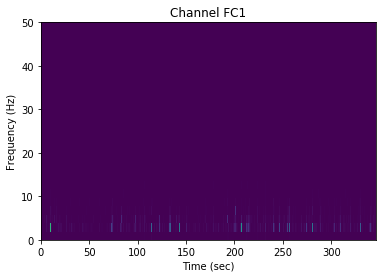

In [26]:
chanOfInt = 'FC1'
f, t, Sxx = scisig.spectrogram(EEGdata_filt[chanOfInt], fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0,50])
plt.title('Channel ' + chanOfInt)
plt.show()

## Epoch and visualize the data
Separate the data by trials (cleaned "raw" data and frequency information) and visually inspect the time-frequency information for the trial conditions. Does power in any particular band look consistently different for math vs non-math trials?

In [66]:
epochs_raw = []
epochs_filt = []

for trial in range(0,len(t_trial_start)):
    t_start = np.round((t_trial_start[trial] - 0 ) * fs)
    t_end = np.round((t_trial_start[trial] + 0.600) * fs)
    epochs_raw.append(EEGdata.loc[t_start:t_end][channels])
    epochs_filt.append(EEGdata_filt.loc[t_start:t_end][channels])
    
    """    
    t_trial_end = t_trial_start[trial] + (0.600 * fs)
    epochs_raw.append(EEGdata.loc[t_trial_start[trial]:t_trial_end][channels])
    epochs_filt.append(EEGdata_filt.loc[t_trial_start[trial]:t_trial_end][channels])
    """

In [28]:
# This ends up returning a list of dataframes where df[trial number][channels]
epochs_raw[0].head()

,Fz,FC1,Cz,C3,C4,Pz,P3
11368,-21763613,-21208670,-99478399,-3777456,-28532842,-1847458,-5501795
11369,-21724178,-21223547,-99513733,-3789377,-28526118,-1854229,-5507612
11370,-21569445,-21176912,-99522936,-3845549,-28449014,-1898432,-5595255
11371,-21443607,-21113827,-99502909,-3904581,-28376153,-1949024,-5698395
11372,-21422579,-21074154,-99464857,-3917313,-28346589,-1958322,-5735302


In [29]:
# See how many trials we have
len(epochs_raw)

279

A useful link on spectrogram settings https://stackoverflow.com/questions/43353172/producing-spectrogram-from-microphone/43454643

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


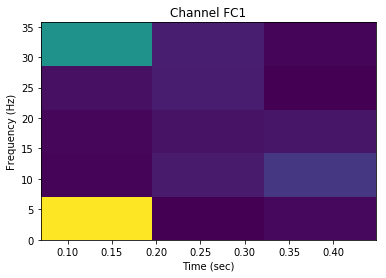

In [30]:
chanOfInt = 'FC1'
trialOfInt = 0

ds_factor = 7 # downsampling factor
f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)

# nperseg determines size of time bins, number of time bins = fs/nperseg - 1

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.title('Channel ' + chanOfInt)
plt.show()

## Compare the data
Compare the average spectrograms for each type of trial

In [31]:
def PlotAverageSpectrogram(epochs, trials, chanOfInt, fs, ds_factor):
    """
    Input
    epochs: your data epochs (raw)
    trials: list or array of trials you wish to include in the average (e.g., all trials of type A)
    chanOfInt: name of the channel of interest
    fs: sampling rate
    ds_factor: downsampling factor
    """

    Sxx_all = list()

    for trialOfInt in trials:
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs[trialOfInt][chanOfInt], ds_factor), fs/ds_factor, nperseg=10)
        # nperseg determines size of time bins, number of time bins = fs/nperseg - 1
        # nperseg = number of segments per second, so 10 = 100 ms chunks
        Sxx_all.append(Sxx)

    Sxx_avg = np.mean(Sxx_all,0)
    
    return f, t, Sxx_avg

### Plot

Plot spectrograms for both error and correct

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GU

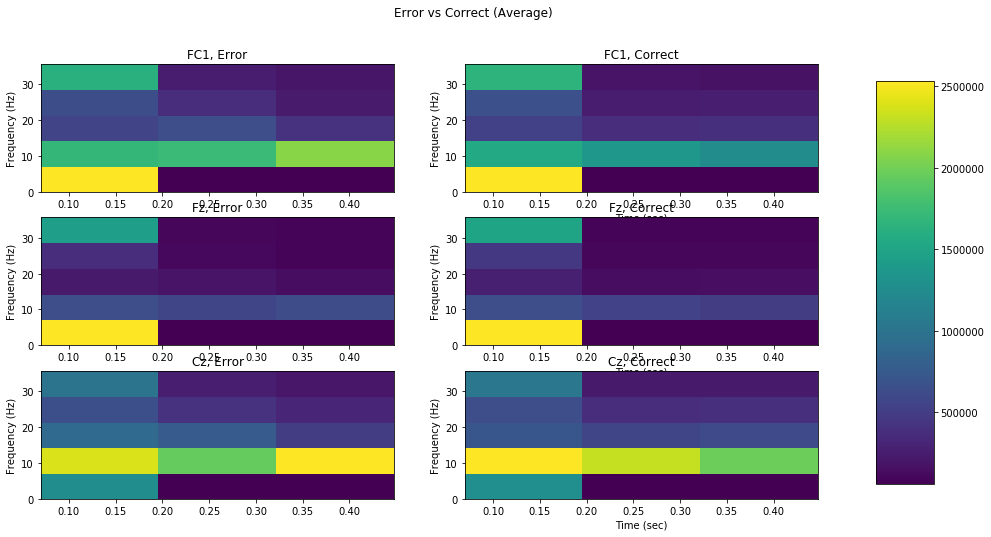

In [32]:
# Get average spectrogram values across trials
channelsOfInt = ['FC1','FC1','Fz','Fz','Cz','Cz']
trials = [error_trials, correct_trials, error_trials, correct_trials, error_trials, correct_trials]
ds_factor = 7 # downsampling factor

# Set up for plotting
Nr = 3
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Error vs Correct (Average)')
i = 0
j = 1

for ax in axes.flat:
    f, t, Sxx_avg = PlotAverageSpectrogram(epochs_raw, trials[i], channelsOfInt[i], fs, ds_factor)
    im = ax.pcolormesh(t, f, Sxx_avg)
    if j%2 == 0:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Correct')
    else:
        ax.set_title(channelsOfInt[i] + ', Error')
    ax.set_ylabel('Frequency (Hz)')
    i += 1
    j += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.show()

Let's also plot the time-series since that's more of what we're interested in

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


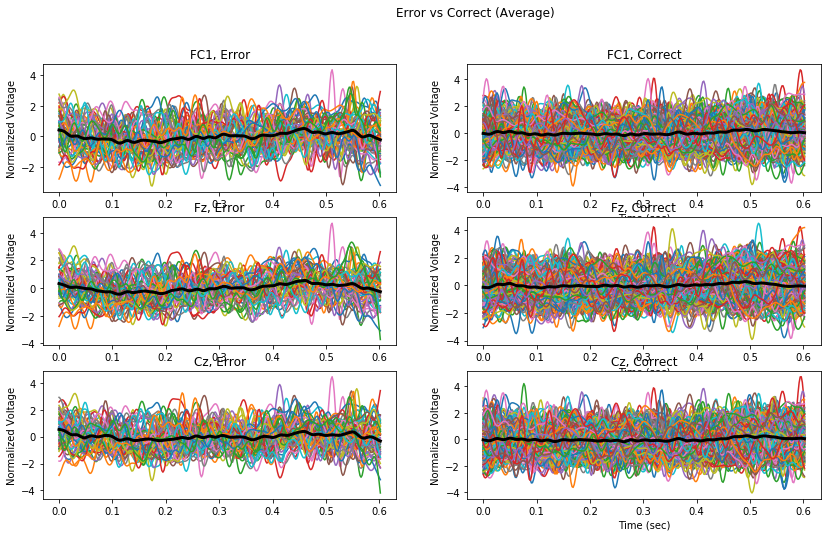

In [33]:
# Make time vector for epochs
time_epoch = np.linspace(0,len(epochs_filt[0]['Fz'])/fs,len(epochs_filt[0]['Fz']))

# Get average timeseries waveform for error and correct
channelsOfInt = ['FC1','FC1','Fz','Fz','Cz','Cz']
trials = [error_trials, correct_trials, error_trials, correct_trials, error_trials, correct_trials]

# Set up for plotting
Nr = 3
Nc = 2
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Error vs Correct (Average)')
i = 0
j = 1

for ax in axes.flat:
    chanOfInt = channelsOfInt[i]
    tmp_to_avg = list()

    for trial in trials[i]:
        tmp1 = epochs_filt[trial][chanOfInt].values
        tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
        #tmp = epochs_filt[trial][chanOfInt].values

        tmp_to_avg.append(tmp)
        ax.plot(time_epoch, tmp)

    # Plot the average in bold black
    ax.plot(time_epoch, np.mean(tmp_to_avg,0), linewidth=3, color='k')

    if j%2 == 0:
        ax.set_xlabel('Time (sec)')
        ax.set_title(channelsOfInt[i] + ', Correct')
    else:
        ax.set_title(channelsOfInt[i] + ', Error')
    ax.set_ylabel('Normalized Voltage')
    i += 1
    j += 1

fig.subplots_adjust(right=0.8)
fig.show()

In [68]:
channels

Index(['Fz', 'FC1', 'Cz', 'C3', 'C4', 'Pz', 'P3'], dtype='object')

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


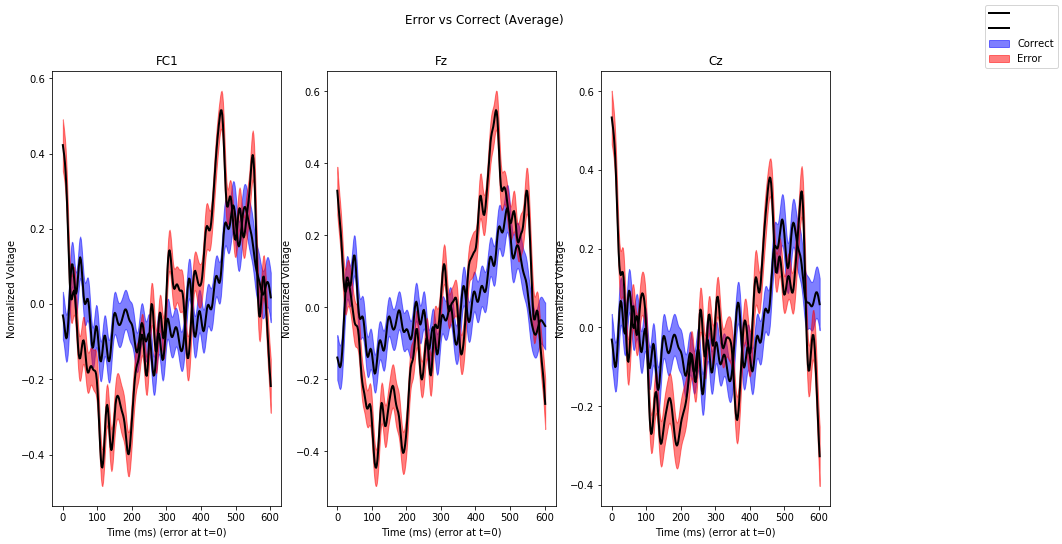

In [73]:
# Make time vector for epochs
time_epoch = np.linspace(0,len(epochs_filt[0]['Fz'])/fs,len(epochs_filt[0]['Fz']))*1000

# Get average timeseries waveform for error and correct
channelsOfInt = ['FC1','FC1','Fz','Fz','Cz','Cz']
trials = [correct_trials, error_trials, correct_trials, error_trials, correct_trials, error_trials]
plot_color = ['b','r','b','r','b','r']

# Set up for plotting
Nr = 1
Nc = 3
fig, axes = plt.subplots(Nr, Nc, figsize=(16,8))
fig.suptitle('Error vs Correct (Average)')
i = 0

for ax in axes.flat:
    chanOfInt = channelsOfInt[i]
    
    for ii in range(0,2):
        df = 1
        tmp_to_avg = list()

        for trial in trials[i]:
            tmp1 = epochs_filt[trial][chanOfInt].values
            tmp = (tmp1 - np.mean(tmp1))/np.std(tmp1)
            #tmp = epochs_filt[trial][chanOfInt].values

            tmp_to_avg.append(tmp)

        # Plot the average in bold black
        mean_line = np.mean(tmp_to_avg,0)
        ax.plot(time_epoch, mean_line, linewidth=2, color='k')

        # Plot standard error (std / sqrt(Nsamples))
        plot_error = np.std(tmp_to_avg,0)/np.sqrt(len(tmp))
        ax.fill_between(time_epoch, mean_line + plot_error, mean_line - plot_error, color=plot_color[i],alpha=0.5)

        
        ax.set_xlabel('Time (ms) (error at t=0)')
        ax.set_title(channelsOfInt[i])
        ax.set_ylabel('Normalized Voltage')
        i += 1

fig.subplots_adjust(right=0.8)
fig.legend(['','','Correct','Error'])
fig.show()

### Save the data

In [35]:
# Store spectrogram data for each trial, for each channel
ds_factor = 4 # downsampling factor
channels_to_use = ['FC1', 'Cz'] # can also specify, like ['C3','C4'], or channels
epochs_Sxx = [[]]*len(channels_to_use)
i = 0

for chanOfInt in channels_to_use:
    tmp = list()
    for trial in range(0,num_of_trials):
        f, t, Sxx = scisig.spectrogram(scisig.decimate(epochs_raw[trial][chanOfInt].T, ds_factor), fs/ds_factor, nperseg=10)
        tmp.append(Sxx.flatten('C')) # if you want all frequency data
        #tmp.append(Sxx[1]) # if you just want second frequency bin (10-20 Hz if you do ds_factor = 3)
    epochs_Sxx[i] = tmp
    i += 1

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [36]:
# Should be num of channels x num of trials x number of spectrogram data points
# So, 7 x 100 x 330
np.shape(epochs_Sxx)

(2, 279, 48)

## Classify epochs
See if you can reliably classify math vs non-math trials (reflecting differences in DMN activity)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

Format the data to feed into a model

In [38]:
epochs_collapsed = []

# Concatenate all epochs such that shape is (num of trials x (flattened channels and spec data))
# So this should be 100 x 2310 (which is 7 channels * 330 spectrogram data points)
num_of_channels = np.shape(epochs_Sxx)[0]
num_of_trials = np.shape(epochs_Sxx)[1]
num_of_specData = np.shape(epochs_Sxx)[2]

epochs_collapsed = np.asarray(epochs_Sxx).reshape(num_of_trials, num_of_channels * num_of_specData)

In [39]:
# Double check we as many examples as we do number of trials
np.shape(epochs_collapsed)

(279, 96)

In [40]:
# Assign your input and labels
X = epochs_collapsed
y = isError

# shuffle data to get train/test
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]

In [41]:
args

array([122,  27,  37,  92,  45, 217, 145, 197,  97, 172,  71, 151, 198,
       193, 223,   9,  26, 148,  68,  54, 229,  73, 236, 141, 128, 206,
       225,  77, 112, 179,  99, 251, 181, 235,  19,  36,  63, 214, 242,
       177, 105, 125,  49, 162,  75, 155, 160,  51, 266,  47,  52,  98,
        10,  55, 237, 134, 101, 102, 149,  46,   0, 254,  84, 110,   7,
        83,  25, 228, 220, 130, 118, 147,   4, 207, 138, 263, 144, 129,
        41, 114, 165, 133,  94,  28, 142,   6,   5, 196, 273, 183, 250,
        60, 187,  14, 233, 124, 120, 226,  34, 230,  64, 238, 246, 182,
       123,  11, 252, 121,  82, 136, 275, 204,  20, 277, 185,  58, 199,
       276,  61, 184,  79,  76, 107, 119, 152, 203, 116,  42, 143, 269,
        56,  74,  65, 161, 224, 278, 255, 188, 245,   2, 232,  31, 264,
       132,  85, 170,  30,  78, 163, 159, 231,  17, 241, 256, 215, 212,
       270, 164, 174, 127, 247, 210, 195, 115, 244,  24,  87, 150, 103,
       190, 189, 259, 253,  32, 113,  48, 139,  44, 173,  21,  4

In [42]:
# Separate into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Determine model parameters

In [43]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
hyper_params = {"C":C_range, "gamma":gamma_range}
grid = GridSearchCV(SVC(kernel='poly'), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)

In [44]:
#grid.fit(X_train, y_train)

In [45]:
#grid.best_estimator_

### Fit the model

In [46]:
svc = SVC(kernel='poly', C=0.01, degree=3, gamma=0.01, verbose=True)
svc.fit(X_train, y_train)

[LibSVM]

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

### Evaluate

In [47]:
print('Using spectrogram data from all channels')
print('Training Score: ' + str(svc.score(X_train, y_train)))
print('Test Score: ' + str(svc.score(X_test, y_test)))

Using spectrogram data from all channels
Training Score: 1.0
Test Score: 0.6071428571428571


Confusion matrix
0 = correct
1 = error

| .              | Pred correct | Pred error |
|----------------|--------------|------------|
| Actual correct | TP           | .          |
| Actual error   | .            | TP         |

In [48]:
confusion_matrix(y_test, svc.predict(X_test))

array([[31, 12],
       [10,  3]], dtype=int64)

### Visualize principal components

In [49]:
from mpl_toolkits.mplot3d import Axes3D

In [50]:
# Run PCA
pca = PCA(n_components=3)
results = pca.fit_transform(X)

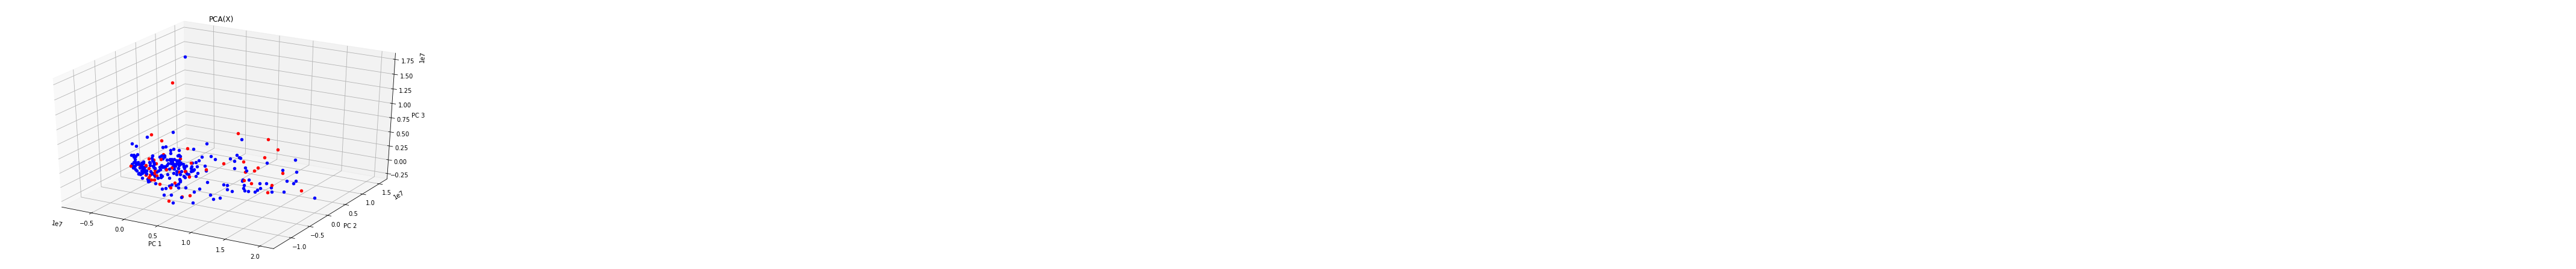

Blue = correct movement, Red = error movement


In [51]:
# Plot
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
i=0
for num in y:
    # print(str(num))
    if num == 0:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='blue')
    elif num == 1:
        ax.scatter(results[i, 0], results[i, 1], results[i, 2], c='red')
    i = i +1

ax.set_title('PCA(X)')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()
print('Blue = correct movement, Red = error movement')

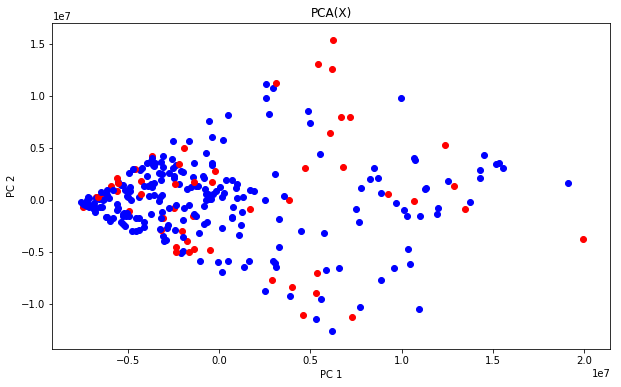

Blue = correct movement, Red = error movement


In [52]:
# Run PCA
pca = PCA(n_components=2)
results = pca.fit_transform(X)

# Plot
fig = plt.figure(figsize=(10,6))
i=0
for num in y:
    # print(str(num))
    if num == 0:
        plt.scatter(results[i, 0], results[i, 1], c='blue')
    elif num == 1:
        plt.scatter(results[i, 0], results[i, 1], c='red')
    i = i +1

plt.title('PCA(X)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
print('Blue = correct movement, Red = error movement')

Visualize classification...

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


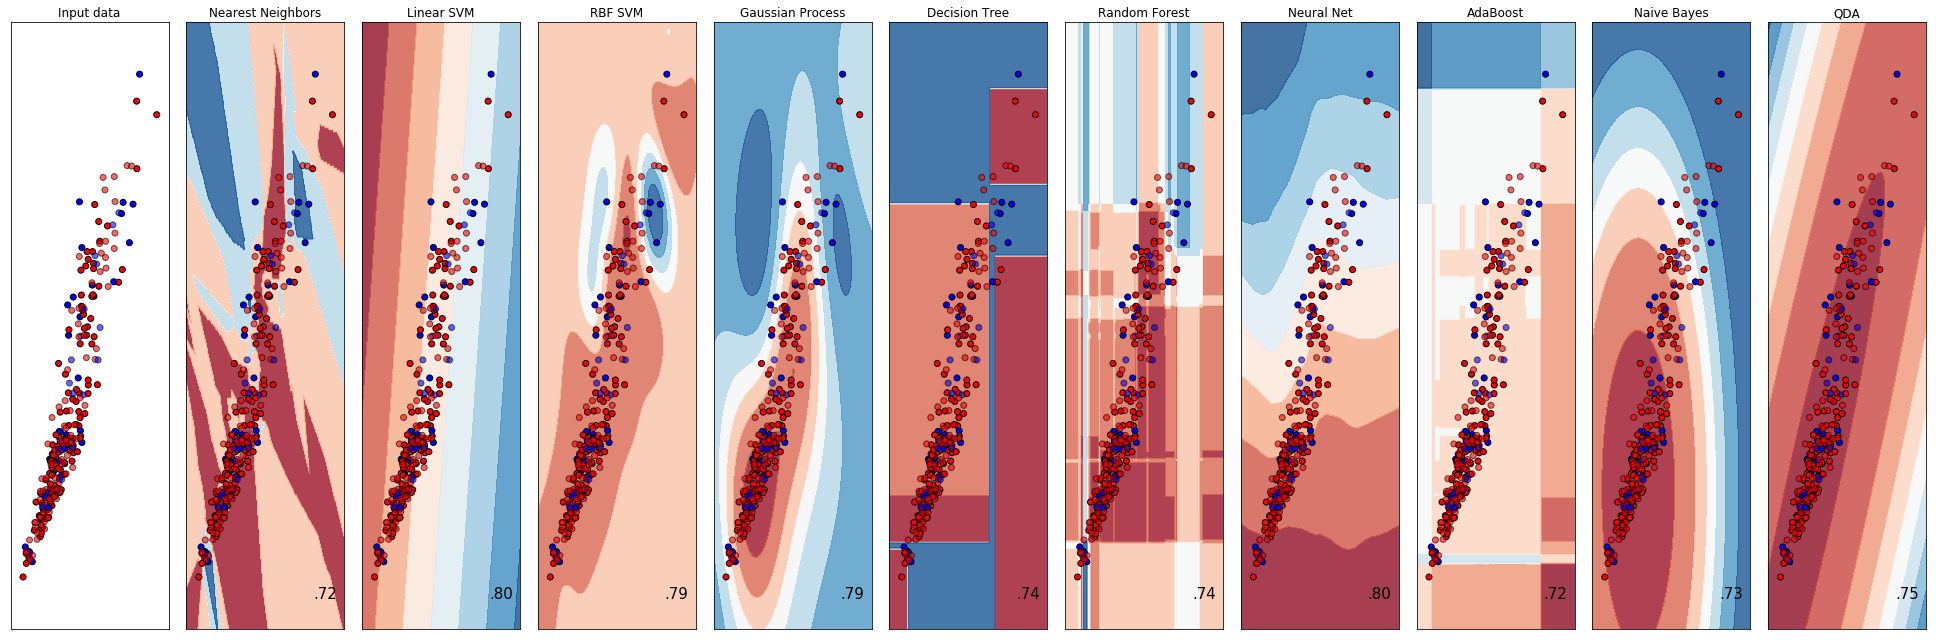

In [53]:
# From https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
i = 1

# preprocess dataset, split into training and test part
X = [np.mean(epochs_collapsed,1),np.std(epochs_collapsed,1)]
X = np.asarray(X).T
np.shape(X)
y = isError
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()
plt.show()

## Let's try other classification
Looking at the results from trying multiple classification methods above, let's use one that looks better than SVM. So here, it looks like random forest might be the best for this current case.

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\tight_layout.py:335: UserWarning: tight_layout not applied: number of columns in subplot specifications mustbe multiples of one another.
  warnings.warn('tight_layout not applied: '


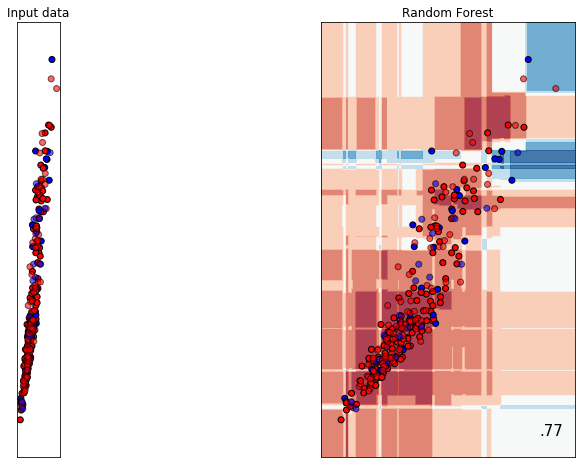

In [54]:
h = .02  # step size in the mesh

figure = plt.figure(figsize=(10, 8))
i = 1

# preprocess dataset, split into training and test part
X = [np.mean(epochs_collapsed,1),np.std(epochs_collapsed,1)]
X = np.asarray(X).T
y = isError
args = np.arange(len(X))
np.random.shuffle(args)
X = [X[i] for i in args]
y = [y[i] for i in args]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
name = "Random Forest"
clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

ax = plt.subplot(1, 1 + 1, i)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
           edgecolors='k', alpha=0.6)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(name)
ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
        size=15, horizontalalignment='right')


plt.tight_layout()
plt.show()

Confusion matrix
0 = correct
1 = error

| .              | Pred correct | Pred error |
|----------------|--------------|------------|
| Actual correct | TP           | .          |
| Actual error   | .            | TP         |

In [55]:
confusion_matrix(y_test, clf.predict(X_test))

array([[85,  5],
       [21,  1]], dtype=int64)

## Save the model

In [56]:
import pickle
import datetime

In [57]:
model = clf
model_file = subjID + '_error_classifier_' + datetime.datetime.now().isoformat()[:10] + '.sav'
pickle.dump(model, open(model_file, 'wb'))

In [58]:
# And to load
loaded_model = pickle.load(open(model_file, 'rb'))
print(loaded_model.score(X_test, y_test))

0.7678571428571429


When you make this all into a function, it should save both the model and the data it was trained/tested on.

**Input**: subjID, EEGdatafile, behavioraldatafile

**Output**: X, y, model

In [59]:
time_to_save = datetime.datetime.now().isoformat()
time_to_save = time_to_save.replace('T','-')
time_to_save = time_to_save.replace(':','-')

In [60]:
filepath_export_data = 'data_for_training_error_' + time_to_save[:19] + '.npz'
np.savez_compressed(filepath_export_data, X=X, y=y)

In [61]:
npzfile = np.load(filepath_export_data)

In [62]:
npzfile.files

['X', 'y']

In [63]:
np.shape(npzfile['X'])

(279, 2)